## 4.1 NLP基础与语言模型

### 4.1.1 序列模型
很多数据都是具有时序信息的，比如说数字货币的收盘价格，如下图所示:
![image-20220316165404313](https://s2.loli.net/2022/03/16/IqeFs1KoO8pDhzm.png)

对序列数据来说：
* 数据值随时间变化而变化
* *音乐*、*语言*、*文本*、和*视频*都是连续的
* 预测明天的股价要比填补昨天遗失的股价更困难

**统计工具:**
在时间$t$观察到$x_t$， 那么得到$T$个不独立的随机变量$(x_1,...,x_T) \sim p(\mathbf{x})$

* 使用条件概率展开

$$
p(a, b)=p(a) p(b \mid a)=p(b) p(a \mid b)
$$

![image-20220204181132691](https://s2.loli.net/2022/02/04/ZuT7gXb85LvaHcN.png)

* 对条件概率建模
  * 也称为自回归模型

$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{1}, \ldots x_{t-1}\right)\right)
$$

**方案A - 马尔科夫假设**

* 假设当前当前数据只跟$\tau$个过去数据点相关

例如在过去数据上训练一个MLP
$$
p\left(x_{t} \mid x_{1}, \ldots x_{t-1}\right)=p\left(x_{t} \mid x_{t-\tau}, \ldots x_{t-1}\right)=p\left(x_{t} \mid f\left(x_{t-\tau,...,x_{t-1}}\right)\right.
$$

**方案B - 潜变量模型(latient variable)**

* 引入潜变量$h_t$来表示过去信息$h_t=f(x_1,...,x_{t-1})$
  * 这样$x_t=p(x_t|h_t)$

![image-20220204181853244](https://s2.loli.net/2022/02/04/BI7aeqKrugTLpn3.png)


下面我们来观看一些列子来直观理解使用MLP来模拟预测时间序列。

首先我们使用正弦函数和一些可加性的噪音来生成我们所需要的序列数据, 时间步长为1, 2,..., 1000。

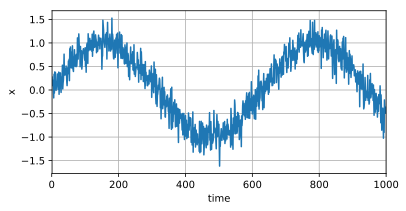

In [2]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

将数据映射为数据对$y_t=x_t$和$\mathbf{x_t} = [x_{t-\tau}, ..., x_{t-1}]$, 这里$\tau$大小为4:

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
features.shape

torch.Size([996, 4])

In [4]:
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

使用一个包含两个FCN的多层感知机

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss()

开始训练模型

In [6]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        print(f'epoch {epoch + 1}',
              f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1 loss: 0.06939396247463792
epoch 2 loss: 0.05837333481758833
epoch 3 loss: 0.054741037470337595
epoch 4 loss: 0.05245873430057576
epoch 5 loss: 0.050843769145247186


预测下一个时间步：

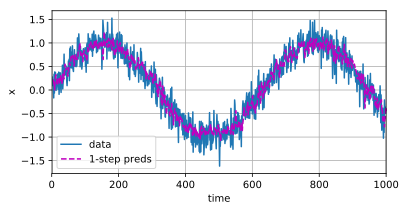

In [7]:
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x',
    legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3)
)

进行多步预测, 发现效果其实挺差的，因为每次**误差都在累计**：

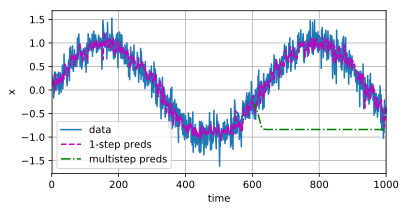

In [8]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

可以明显的看到，马尔科夫假设是无法预测较远的未来的！

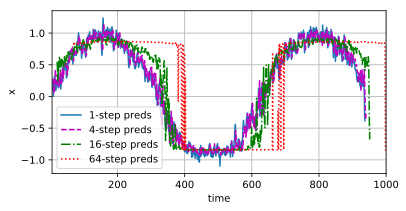

In [9]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i+1）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

### 4.1.2 文本预处理与语言模型
经过上面的分析，下面我们将文本当成给一个时序序列。

#### 文本预处理
* 词元化
* 构建字典

In [10]:
import collections
import re
from d2l import torch as d2l

下面我们使用`API`来下载一本书的文本，将数据集读取到由多跳文本行组成的列表当中:
> 这里我们只做暴力简单的预处理

In [11]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()  # 一行一行读进来
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]  # 标点符号和其他一些符号变成空格

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


##### 词元化 Tokenize
每个文本序列又拆分成一个标记列表

In [12]:
def tokenize(lines, token='word'):
    """
    将文本拆分为单词或者字符词元
    :param lines: 文本列表
    :param token: 词元类型
    :return:
    """
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        raise ValueError

tokens = tokenize(lines)
for i in range(20):  # 看前20个句子的词元
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent']
['lights', 'in', 'the', 'lilies', 'of', 'silver', 'caught', 'the', 'bubbles', 'that', 'flashed', 'and']
['passed', 'in', 'our', 'glasses', 'our', 'chairs', 'being', 'his', 'patents', 'embraced', 'and']
['caressed', 'us', 'rather', 'than', 'submitted', 'to', 'be', 'sat', 'upon', 'and', 'there', 'was', 'that']
['luxurious', 'after', 'dinner', 'atmosphere', 'when', 'thought', 'roams', 'gracefully']
['free', 'of', 'the', 'trammels', 'of', 'precision', 'and', 'he', 'put', 'it', 'to', 'us', 'in', 'this']
['way', 'marking', 'the

##### 词汇表 Vocabulary
构建一个字典（词汇表）：字符串类型的标记映射到从0开始的数字索引中。

用来将字符串类型的词元映射到从0开始的数字索引中。 我们先将训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果称之为**语料**（corpus）。

然后根据每个唯一词元的出现频率，为其分配一个数字索引。 很少出现的词元通常被移除，这可以降低复杂性。

另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元`<unk>`。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（`<pad>`）； 序列开始词元（`<bos>`）； 序列结束词元（`<eos>`）。

In [13]:
class Vocab:
    """字典"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        """
        :param tokens: 词元
        :param min_freq: 少于多少去掉
        :param reserved_tokens: 开始和结束的token
        """
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率从高到低排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)  # 每一个独一无二的token出现的次数

下面我们来构建词汇表:

In [14]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])  # 前10个高频词

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [15]:
print(vocab.idx_to_token[:10])  # 0-9索引对应的词元

['<unk>', 'the', 'i', 'and', 'of', 'a', 'to', 'was', 'in', 'that']


将每一条文本行转换成一个数字索引列表：

In [16]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


下面将本小节上述的所有功能都放到`load_corpus_time_machine`函数当中：
**将单词转换成转成一个数字下标的代码为**:
```python
corpus = [vocab[token] for line in tokens for token in line]
```

In [17]:
def load_corpus_time_machine(max_tokens=-1):
    """
    返回时光机器数据集的标记索引列表和词汇表
    :param max_tokens: 最大词元数量
    :return:
    """
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')  # 注意这里使用了字符作为词元
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]  # 将单词转换成转成一个数字下标
    if max_tokens > 0:
        corpus = corpus[:max_tokens]  # 限定最大读取词元数量
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

#### 语言模型
给定文本序列$x_1,...,x_T$，语言模型的目标是估计联合概率$p(x_1,...,x_T)$，其应用包括：
* 预处理模型(eg BERT, GPT-3)
* 生成文本，给定前面几个次，不断的使用$x_t \sim p(x_t \mid x_1,...,x_{t-1})$来生成后续文本

下面来看使用简单**计数建模**的思想：
* 假设序列长度为2，我们预测:
$$p\left(x, x^{\prime}\right)=p(x) p\left(x^{\prime} \mid x\right)=\frac{n(x)}{n} \frac{n\left(x, x^{\prime}\right)}{n(x)}$$
这里$n$是总次数，$n(x),n(x,x')$是单个单词和连续单词对的出现次数
* 我们可以拓展到长度为3的情况:
$$
                xp\left(x, x^{\prime}, x^{\prime \prime}\right)=p(x) p\left(x^{\prime} \mid x\right) p\left(x^{\prime \prime} \mid x, x^{\prime}\right)=\frac{n(x)}{n} \frac{n\left(x, x^{\prime}\right)}{n(x)} \frac{n\left(x, x^{\prime}, x^{\prime \prime}\right)}{n\left(x, x^{\prime}\right)}
            $$

* 但一直将长度拓展，我们会面临一个问题: 当序列很长时间，由于文本量不够大，很可能$n(x_1,...,x_T) \leq 1$（指数级的复杂度）

使用马尔科夫假设缓解这个问题，提出**N元语法：**
一元，二元，三元语法如下所示:
$$\begin{aligned}
p\left(x_{1}, x_{2}, x_{3}, x_{4}\right) &=p\left(x_{1}\right) p\left(x_{2}\right) p\left(x_{3}\right) p\left(x_{4}\right) \\
&=\frac{n\left(x_{1}\right)}{n} \frac{n\left(x_{2}\right)}{n} \frac{n\left(x_{3}\right)}{n} \frac{n\left(x_{4}\right)}{n} \\
p\left(x_{1}, x_{2}, x_{3}, x_{4}\right) &=p\left(x_{1}\right) p\left(x_{2} \mid x_{1}\right) p\left(x_{3} \mid x_{2}\right) p\left(x_{4} \mid x_{3}\right) \\
&=\frac{n\left(x_{1}\right)}{n} \frac{n\left(x_{1}, x_{2}\right)}{n\left(x_{1}\right)} \frac{n\left(x_{2}, x_{3}\right)}{n\left(x_{2}\right)} \frac{n\left(x_{3}, x_{4}\right)}{n\left(x_{3}\right)} \\
p\left(x_{1}, x_{2}, x_{3}, x_{4}\right) &=p\left(x_{1}\right) p\left(x_{2} \mid x_{1}\right) p\left(x_{3} \mid x_{1}, x_{2}\right) p\left(x_{4} \mid x_{2}, x_{3}\right)
\end{aligned}$$


下面我们引入**数据集**进行实验：

首先，进行词元化与构建字典，与之前说到过的类似

In [18]:
import random
import torch
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]  # 这里不是索引，是单词，与上面有所不同
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]  # 前10个高频词元

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，最高频的词看起来很无聊， 这些词通常被称为**停用词**（stop words）,我们可以画出的词频图:

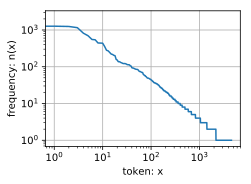

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

通过此图我们可以发现：词频以一种明确的方式迅速衰减。将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。
这意味着单词的频率满足*齐普夫定律*（Zipf's law），即第$i$个最常用单词的频率$n_i$为：

$$n_i \propto \frac{1}{i^\alpha},$$

等价于
$$\log n_i = -\alpha \log i + c,$$

其中$\alpha$是刻画分布的指数，$c$是常数。这告诉我们想要通过计数统计和平滑来建模单词是不可行的，因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。那么其他的词元组合，比如二元语法、三元语法等等，又会如何呢？

我们来看看二元语法与三元语法的频率是否与一元语法的频率表现出相同的行为方式。

* 二元

In [20]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

* 三元

In [21]:
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

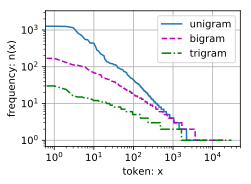

In [22]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

可以分析出:
* 除了一元语法词，单词序列似乎也遵循齐普夫定律，尽管公式中的指数$\alpha$更小（指数的大小受序列长度的影响）。
* 词表中$n$元组的数量并没有那么大，这说明语言中存在相当多的结构，这些结构给了我们应用模型的希望。
* 很多$n$元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。作为代替，我们将使用基于深度学习的模型。

##### 采样方法 mini-batch
> 这里是一个**难点**！请耐心多阅读几次代码!!!

下面展示两种生成mini_batch的方法, 都保证我们所有的数据只会**用过一次**，而之前提到过的序列模型，每个数据都会使用$\tau$次:

1. 随机生成一个小批量数据的特征和标签。在随机采样当中，每个样本都是在原始长序列上任意捕获子序列。
![](https://zh-v2.d2l.ai/_images/timemachine-5gram.svg)

In [23]:
def seq_data_iter_random(corpus, batch_size, num_steps):
    """
    使用随机抽样方式生成一个小批量子序列
    :param corpus:
    :param batch_size:
    :param num_steps:每个子序列中预定义的时间步数，类似于马尔科夫假设的tao
    :return:
    """
    corpus = corpus[random.randint(0, num_steps - 1):] # 随机起始位置，减去1，因为我们需要考虑标签。前面的那几个不要了
    num_subseqs = (len(corpus) - 1) // num_steps  # 切分成num_subseqs份
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))  # 长度为num_steps的子序列的起始索引
    random.shuffle(initial_indices)  # 增强随机性, 注意与下面的第二种采样方法分开

    def data(pos):
        """返回从pos位置开始的长度为num_steps的序列"""
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下面我们**生成一个从$0$到$34$的序列**。假设批量大小为$2$，时间步数为$5$，这意味着可以生成$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。如果设置小批量大小为$2$，我们只能得到$3$个小批量。

In [24]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[15, 16, 17, 18, 19],
        [ 0,  1,  2,  3,  4]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[20, 21, 22, 23, 24],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [26, 27, 28, 29, 30]])


2. 保证两个相邻的小批量中子序列在原始序列也是**相邻**的

在迭代过程中，除了对原始序列可以随机抽样外， 我们还可以保证两个相邻的小批量中的子序列在原始序列上也是**相邻**的。 这种策略在基于小批量的迭代过程中保留了拆分的子序列的顺序，因此称为顺序分区。

In [25]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """
    使用顺序分区生成一个小批量子序列
    :param corpus:
    :param batch_size:
    :param num_steps:
    :return:
    """
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [26]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


下面将两个采样函数包装到一个类当中:

In [28]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

最后，我们定义了一个函数`load_data_time_machine`， 它同时返回数据迭代器和词表， 因此可以与其他带有load_data前缀的函数 （如前面小节中定义的 `d2l.load_data_fashion_mnist`）类似地使用。

In [29]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab